In [ ]:
import pandas as pd

files_info = [
    ("Louvain", "TX", "louvian_cv_results_norm_per_fold_tx.csv"),
    ("Louvain", "TL", "louvian_cv_results_norm_per_fold_tl.csv"),
    ("LPA","TX", "lpa_cv_results_norm_per_fold_tx.csv"),
    ("LPA", "TL", "lpa_cv_results_norm_per_fold_tl.csv"),
    ("SSLPA", "TX", "sslpa_cv_results_norm_per_fold_tx.csv"),
    ("SSLPA", "TL", "sslpa_cv_results_norm_per_fold_tl.csv"),
    ("SC", "TX", "sc_cv_cluster_k65_norm_per_fold_tx.csv"),
    ("SC", "TL", "sc_cv_cluster_k65_norm_per_fold_tl.csv"),
]

rows = []

for method, net, path in files_info:
    df = pd.read_csv(path)

    rows.append({
        "method": method,
        "network": net,

        "Avg_NMI_test_from_folds": df["NMI_test"].mean(),
        "Avg_ARI_test_from_folds": df["ARI_test"].mean(),
        "Avg_Purity_test_from_folds":df["Purity_test"].mean(),

        "Std_NMI_test": df["NMI_test"].std(ddof=1),
        "Std_ARI_test": df["ARI_test"].std(ddof=1),
        "Std_Purity_test":df["Purity_test"].std(ddof=1),
    })

fold_summary = pd.DataFrame(rows)
print(fold_summary)


    method network  Avg_NMI_test_from_folds  Avg_ARI_test_from_folds  \
0  Louvain      TX                 0.268240                 0.009028   
1  Louvain      TL                 0.273608                 0.023718   
2      LPA      TX                 0.428687                 0.004848   
3      LPA      TL                 0.318257                 0.033819   
4    SSLPA      TX                 0.560393                 0.440075   
5    SSLPA      TL                 0.323706                 0.127071   
6       SC      TX                 0.359427                 0.059529   
7       SC      TL                 0.242565                 0.206742   

   Avg_Purity_test_from_folds  Std_NMI_test  Std_ARI_test  Std_Purity_test  
0                    0.733006      0.020762      0.011502         0.010110  
1                    0.913757      0.095659      0.033037         0.019109  
2                    0.853892      0.023005      0.030815         0.014529  
3                    0.964021      0.082905

In [8]:
base = pd.read_csv("../community_detection_cv_summary_all.csv")

merged = base.merge(
    fold_summary[["method","network","Std_NMI_test","Std_ARI_test","Std_Purity_test"]],
    on=["method","network"],
    how="left"
)

merged.to_csv("community_detection_cv_summary_all_with_std.csv", index=False)


/tmp/ipykernel_1580027/23543618.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("network", as_index=True)["coverage"].mean().round(4).to_dict()
/tmp/ipykernel_1580027/23543618.py:47: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  means = [float(sub.loc[sub["method"] == m, mean_col]) for m in METHOD_ORDER]
/tmp/ipykernel_1580027/23543618.py:48: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  stds  = [float(sub.loc[sub["method"] == m, std_col])  for m in METHOD_ORDER]
/tmp/ipykernel_1580027/23543618.py:47: FutureWarning: Calling float on a single element Series is deprecated and will raise a 

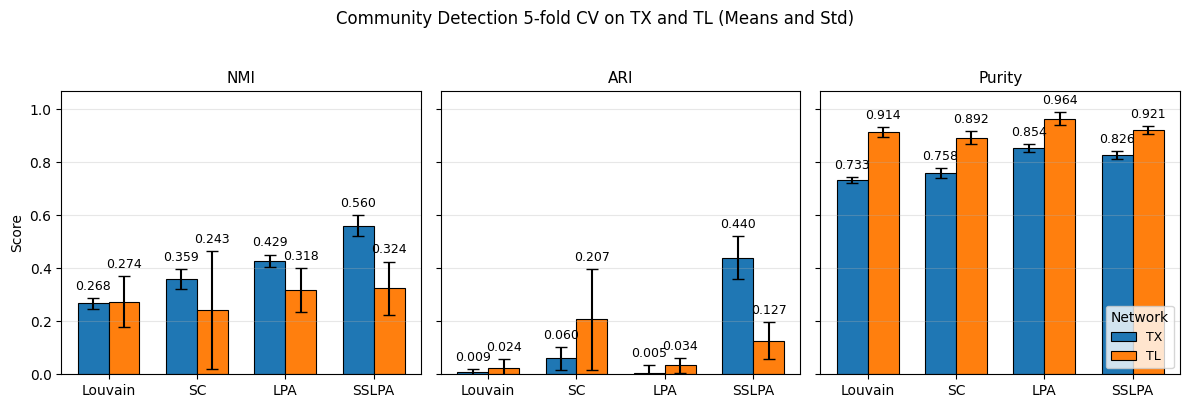

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

CSV = "community_detection_cv_summary_all_with_std.csv"
METHOD_ORDER  = ["Louvain", "SC", "LPA", "SSLPA"]
NETWORK_ORDER = ["TX", "TL"]
METRICS = [
    ("Avg_NMI_test", "Std_NMI_test", "NMI"),
    ("Avg_ARI_test", "Std_ARI_test", "ARI"),
    ("Avg_Purity_test", "Std_Purity_test", "Purity"),
]

COLORS = {"TX": "#1f77b4", "TL": "#ff7f0e"}
HATCH  = {"TX": "", "TL": ""}
ROUND_TO = 3

df = pd.read_csv(CSV)
df["method"]  = pd.Categorical(df["method"], METHOD_ORDER,  ordered=True)
df["network"] = pd.Categorical(df["network"], NETWORK_ORDER, ordered=True)
df = df.sort_values(["method", "network"]).reset_index(drop=True)

coverage_by_net = (
    df.groupby("network", as_index=True)["coverage"].mean().round(4).to_dict()
)

plt.rcParams.update({
    "font.size": 10,
    "axes.titlesize": 11,
    "axes.labelsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 9,
})

fig, axes = plt.subplots(1, 3, figsize=(12, 4.2), sharey=True)
bar_width = 0.35
x = np.arange(len(METHOD_ORDER))

for i, (mean_col, std_col, label) in enumerate(METRICS):
    ax = axes[i]
    ymax = 0.0

    for j, net in enumerate(NETWORK_ORDER):
        sub = df[df["network"] == net]

        means = [float(sub.loc[sub["method"] == m, mean_col]) for m in METHOD_ORDER]
        stds  = [float(sub.loc[sub["method"] == m, std_col])  for m in METHOD_ORDER]

        ymax = max(ymax, max(np.array(means) + np.array(stds)))

        bars = ax.bar(
            x + j * bar_width,
            means,
            yerr=stds,
            width=bar_width,
            label=net if i == 2 else None,
            color=COLORS[net],
            hatch=HATCH[net],
            edgecolor="black",
            linewidth=0.8,
            capsize=4,
        )

        for bar, val, sd in zip(bars, means, stds):
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() + sd + 0.02,  
                f"{val:.{ROUND_TO}f}",
                ha="center",
                va="bottom",
                fontsize=9,
            )

    ax.set_title(label)
    ax.set_xticks(x + bar_width / 2)
    ax.set_xticklabels(METHOD_ORDER)

    upper = min(1.08, ymax + 0.08)
    ax.set_ylim(0, upper)

    ax.grid(alpha=0.3, axis="y")
    if i == 0:
        ax.set_ylabel("Score")
    if i == 2:
        leg = ax.legend(
            title="Network",
            loc="lower right",
            frameon=True,
            edgecolor="0.8",
        )
        leg._legend_box.align = "left"

fig.suptitle(
    "Community Detection 5-fold CV on TX and TL (Means and Std)",
    y=0.98,
    fontsize=12,
)
tx_cov = coverage_by_net.get("TX", np.nan) * 100
tl_cov = coverage_by_net.get("TL", np.nan) * 100


fig.tight_layout(rect=[0, 0.02, 1, 0.95])
plt.show()
